# Import libraries

In [3]:
#Import python libs
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import expon
from scipy.stats import norm
from scipy.stats import uniform
from numpy.random import random
import os
import glob
import pandas as pd
plt.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 18})

# Define functions

In [8]:
def UniqueVals(stims, responses):
    
    """
    Takes stimulus values and responses and calculates N (total number of trials) and K (number of responses of interest) 
    for each unique stimulus values
    
    Inputs:
    stims = vector of all stimuli
    responses = vector of all responses
    
    Outputs:
    unique_stims = vector of the unrepeated stimulus locations
    Nstims = the number of times each unique stim was visited (vector)
    Kleft = the number of times the response was left at each stim location
    """
    
    unique_stims, stim_idx = np.unique(stims, return_index=True)
    Nstims, Kleft = [], []
    for u in unique_stims:
        stim_idx = np.argwhere(u==stims)
        Nstims = np.append(Nstims,len(stim_idx))
        Kleft = np.append(Kleft, np.sum(responses[stim_idx]))
        
    return unique_stims, Nstims, Kleft

In [9]:
#Look up table
def Psi_lookT(X,a_range,b_range):
    """
    This function creates two lookup tables required for the psi algorithm to run more efficiently
    It is a table of probabilities for both responses (left and right in this case) given all possible
    alpha and beta values and all possible stimulus locations:
    p(r='left'|alpha,beta,X)
    p(r='right'|alpha,beta,X)
    """
    
    # #Set these nuisance parameters to nonzero values
    # gam = 0.02
    # lam = 0.02
    
    #Preallocate the lookup tables
    p_left_look = np.empty([len(b_range),len(a_range),(len(X))])
    p_right_look = np.empty([len(b_range),len(a_range),(len(X))])
    
    #Loop through all possible stimulus, alpha and beta values
    for x_i, x in enumerate(X):
        for a_i, a in enumerate(a_range):
            for b_i, b in enumerate(b_range):
                psi = norm.cdf(x,a,b)
                # psi = gam + (1 - lam - gam) * norm.cdf(x,a,b)
                p_left_look[b_i,a_i,x_i] = psi
                p_right_look[b_i,a_i,x_i] = 1-psi

    return p_left_look, p_right_look

In [10]:
#Entropy
def CalcH(X, p_left_look, p_right_look, Prior):

    """
    This function calculates the entropy (H) of each possible stimulus value to determine which one minimizes,
    the entropy for the next trial. This is the stimulus that will provide the most information for both parameters
    """
    
    #Simulate through each possible stim value, X
    EH, Post_left, Post_right = [], [], []
    for i, x in enumerate(X):

        #Calculate the probability of getting a response, r, after presenting test x at the next trial (across all possible parameter values)
        p_left = np.nansum(np.nansum(np.multiply(p_left_look[:,:,i],Prior)))
        p_right = np.nansum(np.nansum(np.multiply(p_right_look[:,:,i],Prior)))

        #Calculate the posterior for each response 
        Post_left = p_left_look[:,:,i]*Prior
        Post_left = Post_left / p_left
        Post_right = p_right_look[:,:,i]*Prior
        Post_right = Post_right / p_right

        #Estimate the entropy of the posterior distribution for each response
        H_left = -np.nansum(np.nansum(Post_left * np.log2(Post_left)))
        H_right = -np.nansum(np.nansum(Post_right * np.log2(Post_right)))
        
        #Combine the entropy calculations, weighted by their probabilities
        Total_H = (H_left*p_left) + (H_right*p_right)
        EH = np.append(EH, Total_H)
        
    best_X = X[np.argmin(EH)]
    
    return EH, best_X

In [11]:
def calc_CCC(sim,est):
    """
    This function calculate the correspondance correlation coefficient
    """
    #Claculate rho
    r, _ = stats.pearsonr(sim,est)

    #Calculate CCC
    CCC = (2*r*np.std(sim)*np.std(est)) / ((np.mean(sim) - np.mean(est))**2 + (np.var(sim) + np.var(est)))

    return CCC

In [12]:
def sim_psi_KT(params, Ntrials, X, a_range, b_range, p_left_look, p_right_look, Prior):
    
    alpha = params[0]
    beta = params[1]
    
    stims, responses, alpha_EV, beta_EV = [], [], [], []
    for i in range(Ntrials):
        
        #Calculate the best stim position
        _, best_X = CalcH(X, p_left_look, p_right_look, Prior)
        stims = np.append(stims, best_X)
        
        #Simualte a response based on the parameters
        responses = np.append(responses, norm.cdf(best_X, alpha, beta) > np.random.rand())

        #Index the posterior
        stim_idx = np.argwhere(stims[i]==X)[0][0]
        if responses[i]==1:
            Posterior = p_left_look[:,:,stim_idx]*Prior
        elif responses[i]==0:
            Posterior = p_right_look[:,:,stim_idx]*Prior
        Posterior = Posterior/np.nansum(np.nansum(Posterior))
        
        #Marginalize the posterior
        alpha_post = np.nansum(Posterior,axis=0)
        beta_post = np.nansum(Posterior,axis=1)

        #Calculate the expected value of each
        alpha_EV = np.append(alpha_EV, np.nansum(a_range*alpha_post))
        beta_EV = np.append(beta_EV, np.nansum(b_range*beta_post))

        #The posterior becomes the prior for the next trial
        Prior = Posterior        
        
    return stims, responses, alpha_EV, beta_EV

In [13]:
def sim_psi_1(params, Ntrials, X, a_range, b_range, p_left_look, p_right_look, Prior):
    
    alpha = params[0]
    beta = params[1]
    
    stims, responses, alpha_EV, beta_EV = [], [], [], []
    for i in range(Ntrials):
        
        #Calculate the best stim position
        _, best_X = CalcH(X, p_left_look, p_right_look, Prior)
        stims = np.append(stims, best_X)
        
        #Simualte a response based on the parameters
        responses = np.append(responses, norm.cdf(best_X, alpha, beta) > np.random.rand())
        
        #Account for repeated stimuli 
        Unique_stims, Nstims, Kleft = UniqueVals(stims, responses)

        #Calcualte the likelihood for the response given the current parameters
        Likelihood = np.empty((len(b_range),len(a_range)))
        for a_idx, a in enumerate(a_range):
            for b_idx, b in enumerate(b_range):
                psi = norm.cdf(Unique_stims,a,b)
                Likelihood[b_idx,a_idx] = np.prod((psi**Kleft) * ((1-psi)**(Nstims-Kleft)))

        #Calculate the posterior
        Posterior = Likelihood*Prior
        Posterior = Posterior/np.nansum(np.nansum(Posterior))
        
        #Marginalize the posterior
        alpha_post = np.nansum(Posterior,axis=0)
        beta_post = np.nansum(Posterior,axis=1)

        #Calculate the expected value of each
        alpha_EV = np.append(alpha_EV, np.nansum(a_range*alpha_post))
        beta_EV = np.append(beta_EV, np.nansum(b_range*beta_post))

        #The posterior becomes the prior for the next trial
        Prior = Posterior        
            
    return stims, responses, alpha_EV, beta_EV

In [14]:
def compare_post_calcs(test):
    
    SID = test.SID[0] + test.Test[0]
    
    BslDiff = round(test.BslDiff.values[0])
    Responses = test.BinaryResponses.values
    Stims = test.AllStims.values + BslDiff

    X = np.arange(-100,110,10) 
    a_range = np.linspace(-100,100,201) 
    b_range = np.linspace(0.001,100,201)
    p_left_look, p_right_look = Psi_lookT(X, a_range, b_range)

    #Set the priors
    p_alpha = norm.pdf(a_range, 0, 20)
    p_beta = expon.pdf(b_range,0,20)
    p_alpha = np.reshape(p_alpha,(1,len(p_alpha)))
    p_beta = np.reshape(p_beta,(1,len(p_beta)))
    Prior = p_beta.T @ p_alpha 

    Prior_1 = Prior
    Prior_2 = Prior
    
    stims, responses, max_lik_alpha, max_lik_beta, alpha_EV_1, beta_EV_1, alpha_EV_2, beta_EV_2 = [], [], [], [], [], [], [], []
    for t in range(len(Responses)):
        
        #Record the stim and response
        stims = np.append(stims, Stims[t])
        responses = np.append(responses, Responses[t])

        #Account for repeated stimuli 
        Unique_stims, Nstims, Kleft = UniqueVals(stims, responses)
        current_stim_idx = np.argwhere(Unique_stims==Stims[t])

        #Calcualte the likelihood for the response given the current parameters
        Likelihood = np.empty((len(b_range),len(a_range)))
        for a_idx, a in enumerate(a_range):
            for b_idx, b in enumerate(b_range):
                psi = norm.cdf(Unique_stims,a,b)
                Likelihood[b_idx,a_idx] = np.prod((psi**Kleft) * ((1-psi)**(Nstims-Kleft)))

        #Index the max likelihood for each
        lik_max_idx = np.unravel_index(Likelihood.argmax(), Likelihood.shape)
        max_lik_alpha = a_range[lik_max_idx[1]]
        max_lik_beta = b_range[lik_max_idx[0]]

        #Calculate the posterior
        Posterior_1 = Likelihood*Prior_1                    
        Posterior_1 = Posterior_1/np.nansum(np.nansum(Posterior_1))
        #Marginalize the posterior
        alpha_post_1 = np.nansum(Posterior_1,axis=0)
        beta_post_1 = np.nansum(Posterior_1,axis=1)
        #Calculate the expected value of each
        alpha_EV_1 = np.append(alpha_EV_1, np.nansum(a_range*alpha_post_1))
        beta_EV_1 = np.append(beta_EV_1, np.nansum(b_range*beta_post_1))  

        #Alt posterior calc
        stim_idx = np.argwhere(Stims[t]==X)[0][0]
        if Responses[t]==1:
            Posterior_2 = p_left_look[:,:,stim_idx]*Prior_2
        elif Responses[t]==0:
            Posterior_2 = p_right_look[:,:,stim_idx]*Prior_2
        Posterior_2 = Posterior_2/np.nansum(np.nansum(Posterior_2))
        #Marginalize the posterior
        alpha_post_2 = np.nansum(Posterior_2,axis=0)
        beta_post_2 = np.nansum(Posterior_2,axis=1)
        #Calculate the expected value of each
        alpha_EV_2 = np.append(alpha_EV_2, np.nansum(a_range*alpha_post_2))
        beta_EV_2 = np.append(beta_EV_2, np.nansum(b_range*beta_post_2))  

        Prior_1 = Posterior_1
        Prior_2 = Posterior_2
        
    trials = test.Trial_num.values
    selected_stims = test.SelectedStims.values
    a_est = test.Alpha_EV.values + BslDiff
    b_est = test.Beta_EV.values

    fig, ax = plt.subplots(figsize=(15,7),tight_layout=True)  
    ax.plot(trials, Stims,'b',alpha=0.5)
    ax.plot(trials[(selected_stims==0) & (Responses==1)], Stims[(selected_stims==0) & (Responses==1)],'bo', markersize=7, label='Response = Left')
    ax.plot(trials[(selected_stims==0) & (Responses==0)], Stims[(selected_stims==0) & (Responses==0)],'bo',fillstyle='none', markersize=7, label='Response = Right')
    ax.plot(trials[(selected_stims==1) & (Responses==1)], Stims[(selected_stims==1) & (Responses==1)],'co', markersize=7, label='Pre-selected Stims')
    ax.plot(trials[(selected_stims==1) & (Responses==0)], Stims[(selected_stims==1) & (Responses==0)],'co',fillstyle='none', markersize=7)
    ax.plot(trials,np.zeros(len(test)),'k')
    ax.plot(trials,alpha_EV_1,'b-',label='Alpha est sim')
    ax.plot(trials,alpha_EV_2,'b--',label='Alpha est new')
    ax.plot(trials,beta_EV_1,'r-',label='Beta est sim')
    ax.plot(trials,beta_EV_2,'r--',label='Beta est new')    
    ax.set(xlabel='Trial Num.', xlim=(0,len(test)+1), title=SID,ylabel='Foot Difference (L-R)')
    ax.legend()    
    plt.show()
    
    return alpha_EV_1, alpha_EV_2, beta_EV_1, beta_EV_2

# Simulate an individual

In [110]:
Ntrials = 75
alpha = 0
beta = 10
params = [alpha, beta]

X = np.arange(-100,110,10)
a_range = np.linspace(-100,100,201) 
b_range = np.linspace(0.001,100,201)
p_left_look, p_right_look = Psi_lookT(X, a_range, b_range)

#Set the priors
p_alpha = norm.pdf(a_range,0, 20)
p_beta = expon.pdf(b_range,0,20)
p_alpha = np.reshape(p_alpha,(1,len(p_alpha)))
p_beta = np.reshape(p_beta,(1,len(p_beta)))
Prior = p_beta.T @ p_alpha

_, _, alpha_EV_KV, beta_EV_KV = sim_psi_KT(params, Ntrials, X, a_range, b_range, p_left_look, p_right_look, Prior)
_, _, alpha_EV_1, beta_EV_1 = sim_psi_1(params, Ntrials, X, a_range, b_range, p_left_look, p_right_look, Prior)

C:\Users\Jonathan\AppData\Local\Temp/ipykernel_2056/80654259.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(Post_left * np.log2(Post_left)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_2056/80654259.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(Post_left * np.log2(Post_left)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_2056/80654259.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(Post_right * np.log2(Post_right)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_2056/80654259.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(Post_right * np.log2(Post_right)))


In [114]:
print(alpha_EV_KV[-1], alpha_EV_1[-1])
print(beta_EV_KV[-1], beta_EV_1[-1])

0.58027024448998 -0.7391568186665455
11.063174280384844 6.5765131547928


# Simulate multiple subjects at 50 trials

0


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_7804/80654259.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(Post_left * np.log2(Post_left)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_7804/80654259.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(Post_left * np.log2(Post_left)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_7804/80654259.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(Post_right * np.log2(Post_right)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_7804/80654259.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(Post_right * np.log2(Post_right)))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


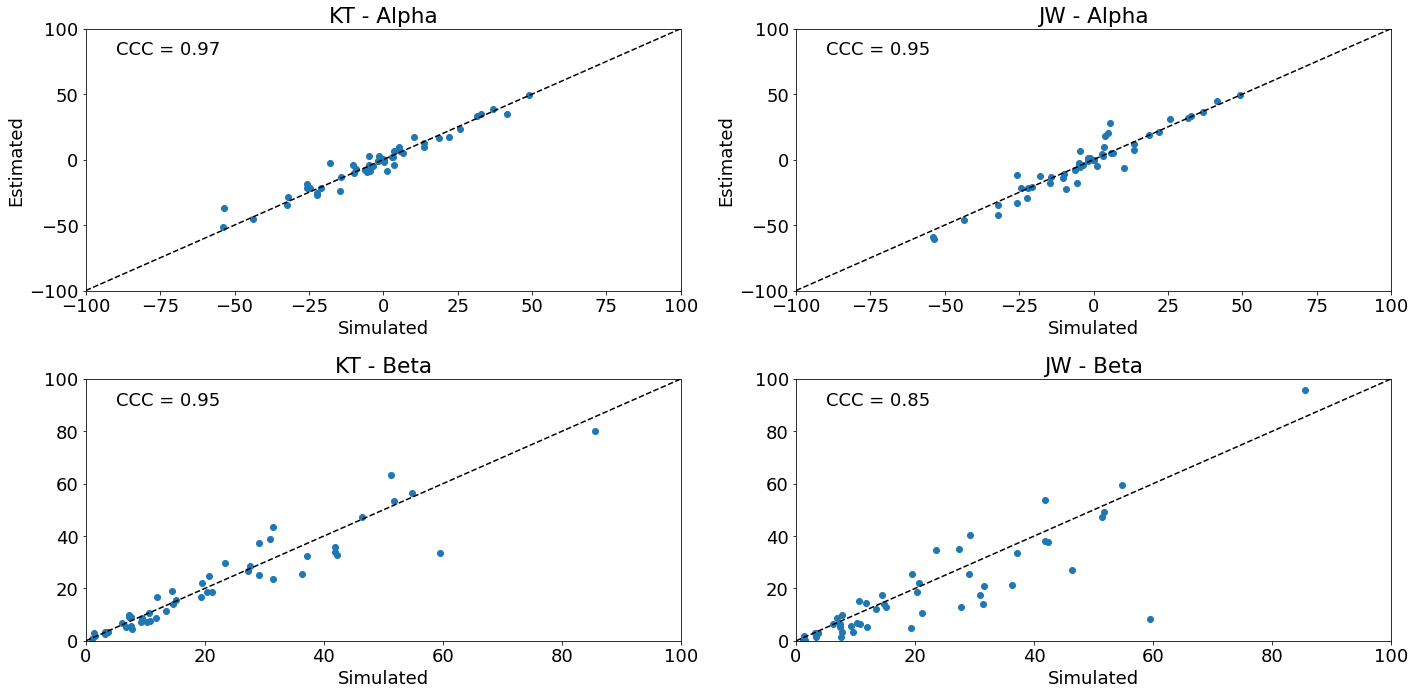

In [76]:
Nsubjs = 50
Ntrials = 50
X = np.arange(-100,110,10)
a_range = np.linspace(-100,100,201) 
b_range = np.linspace(0.001,100,201)
p_left_look, p_right_look = Psi_lookT(X, a_range, b_range)

p_alpha = norm.pdf(a_range,0, 20)
p_beta = expon.pdf(b_range,0,20)
p_alpha = np.reshape(p_alpha,(1,len(p_alpha)))
p_beta = np.reshape(p_beta,(1,len(p_beta)))

alpha_sim, beta_sim, alpha_est_KT, beta_est_KT, alpha_est_JW, beta_est_JW = [], [], [], [], [], []
for s in range(Nsubjs):
    print(s)
    alpha_sim = np.append(alpha_sim, norm.rvs(0,20))
    beta_sim = np.append(beta_sim, expon.rvs(0,20))
    params = [alpha_sim[s], beta_sim[s]]

    #Set the priors
    Prior = p_beta.T @ p_alpha

    #Run the sims
    _, _, alpha_EV, beta_EV = sim_psi_KT(params, Ntrials, X, a_range, b_range, p_left_look, p_right_look, Prior)
    alpha_est_KT = np.append(alpha_est_KT, alpha_EV[-1])
    beta_est_KT = np.append(beta_est_KT, beta_EV[-1])
    
    _, _, alpha_EV, beta_EV = sim_psi_1(params, Ntrials, X, a_range, b_range, p_left_look, p_right_look, Prior)
    alpha_est_JW = np.append(alpha_est_JW, alpha_EV[-1])
    beta_est_JW = np.append(beta_est_JW, beta_EV[-1])    
    
KT_alpha_ccc = calc_CCC(alpha_sim,alpha_est_KT)
JW_alpha_ccc = calc_CCC(alpha_sim,alpha_est_JW)
KT_beta_ccc = calc_CCC(beta_sim,beta_est_KT)
JW_beta_ccc = calc_CCC(beta_sim,beta_est_JW)

#Plot
fig, ax = plt.subplots(2,2,figsize=(20,10), tight_layout=True)
ax[0,0].plot(alpha_sim,alpha_est_KT,'o')
ax[0,0].plot(a_range,a_range,'k--')
ax[0,0].text(-90,80,'CCC = ' + str(round(KT_alpha_ccc,2)))
ax[0,0].set(xlim=(-100, 100),ylim=(-100,100),xlabel='Simulated',ylabel='Estimated',title='KT - Alpha')

ax[1,0].plot(beta_sim,beta_est_KT,'o')
ax[1,0].plot(b_range,b_range,'k--')
ax[1,0].text(5,90,'CCC = ' + str(round(KT_beta_ccc,2)))
ax[1,0].set(xlim=(0, 100), ylim=(0,100),xlabel='Simulated',title='KT - Beta')

ax[0,1].plot(alpha_sim,alpha_est_JW,'o')
ax[0,1].plot(a_range,a_range,'k--')
ax[0,1].text(-90,80,'CCC = ' + str(round(JW_alpha_ccc,2)))
ax[0,1].set(xlim=(-100, 100),ylim=(-100,100),xlabel='Simulated',ylabel='Estimated',title='JW - Alpha')

ax[1,1].plot(beta_sim,beta_est_JW,'o')
ax[1,1].plot(b_range,b_range,'k--')
ax[1,1].text(5,90,'CCC = ' + str(round(JW_beta_ccc,2)))
ax[1,1].set(xlim=(0, 100), ylim=(0,100),xlabel='Simulated',title='JW - Beta')
plt.show()

# Simulate multiple subjects at 75 trials

0


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_7804/80654259.py:24: RuntimeWarning: divide by zero encountered in log2
  H_left = -np.nansum(np.nansum(Post_left * np.log2(Post_left)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_7804/80654259.py:24: RuntimeWarning: invalid value encountered in multiply
  H_left = -np.nansum(np.nansum(Post_left * np.log2(Post_left)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_7804/80654259.py:25: RuntimeWarning: divide by zero encountered in log2
  H_right = -np.nansum(np.nansum(Post_right * np.log2(Post_right)))
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_7804/80654259.py:25: RuntimeWarning: invalid value encountered in multiply
  H_right = -np.nansum(np.nansum(Post_right * np.log2(Post_right)))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_7804/80654259.py:21: RuntimeWarning: invalid value encountered in true_divide
  Post_right = Post_right / p_right


19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_7804/80654259.py:19: RuntimeWarning: invalid value encountered in true_divide
  Post_left = Post_left / p_left


40
41
42
43
44
45
46
47
48
49


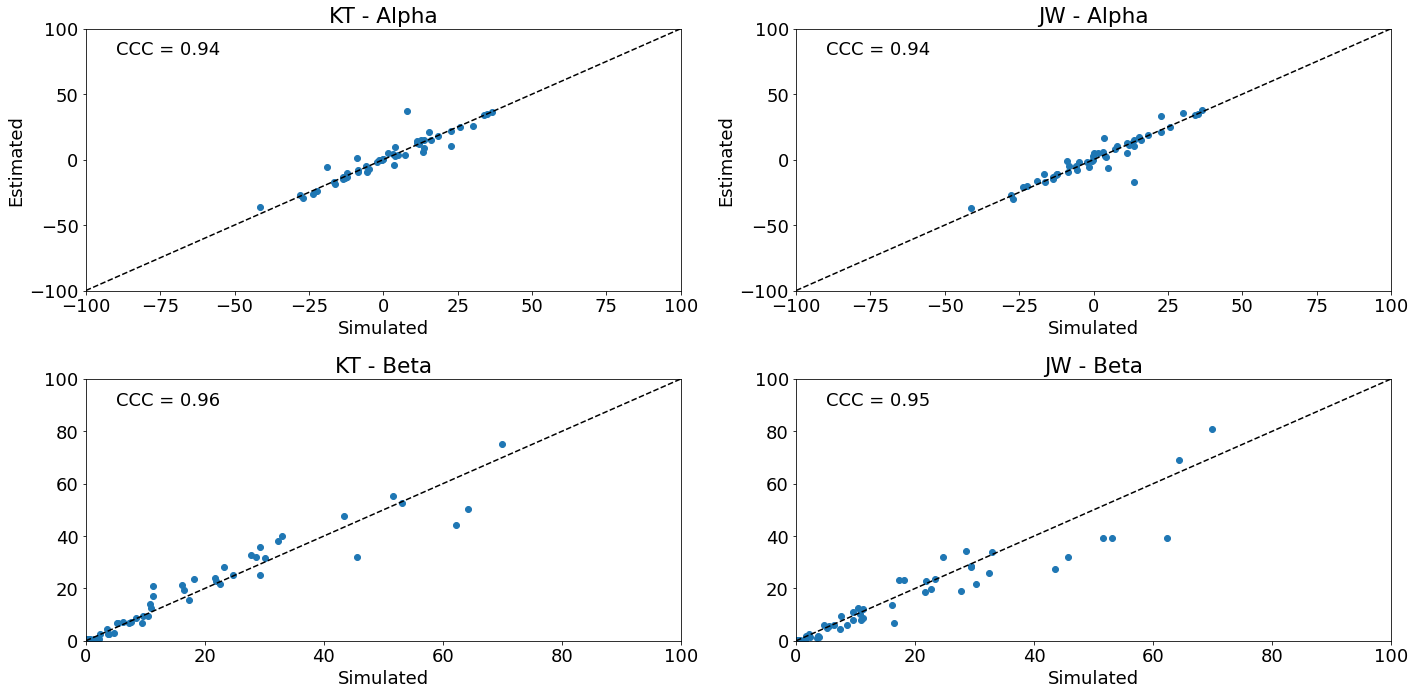

In [77]:
Nsubjs = 50
Ntrials = 75
X = np.arange(-100,110,10)
a_range = np.linspace(-100,100,201) 
b_range = np.linspace(0.001,100,201)
p_left_look, p_right_look = Psi_lookT(X, a_range, b_range)

p_alpha = norm.pdf(a_range,0, 20)
p_beta = expon.pdf(b_range,0,20)
p_alpha = np.reshape(p_alpha,(1,len(p_alpha)))
p_beta = np.reshape(p_beta,(1,len(p_beta)))

alpha_sim, beta_sim, alpha_est_KT, beta_est_KT, alpha_est_JW, beta_est_JW = [], [], [], [], [], []
for s in range(Nsubjs):
    print(s)
    alpha_sim = np.append(alpha_sim, norm.rvs(0,20))
    beta_sim = np.append(beta_sim, expon.rvs(0,20))
    params = [alpha_sim[s], beta_sim[s]]

    #Set the priors
    Prior = p_beta.T @ p_alpha

    #Run the sims
    _, _, alpha_EV, beta_EV = sim_psi_KT(params, Ntrials, X, a_range, b_range, p_left_look, p_right_look, Prior)
    alpha_est_KT = np.append(alpha_est_KT, alpha_EV[-1])
    beta_est_KT = np.append(beta_est_KT, beta_EV[-1])
    
    _, _, alpha_EV, beta_EV = sim_psi_1(params, Ntrials, X, a_range, b_range, p_left_look, p_right_look, Prior)
    alpha_est_JW = np.append(alpha_est_JW, alpha_EV[-1])
    beta_est_JW = np.append(beta_est_JW, beta_EV[-1])    
    
KT_alpha_ccc = calc_CCC(alpha_sim,alpha_est_KT)
JW_alpha_ccc = calc_CCC(alpha_sim,alpha_est_JW)
KT_beta_ccc = calc_CCC(beta_sim,beta_est_KT)
JW_beta_ccc = calc_CCC(beta_sim,beta_est_JW)

#Plot
fig, ax = plt.subplots(2,2,figsize=(20,10), tight_layout=True)
ax[0,0].plot(alpha_sim,alpha_est_KT,'o')
ax[0,0].plot(a_range,a_range,'k--')
ax[0,0].text(-90,80,'CCC = ' + str(round(KT_alpha_ccc,2)))
ax[0,0].set(xlim=(-100, 100),ylim=(-100,100),xlabel='Simulated',ylabel='Estimated',title='KT - Alpha')

ax[1,0].plot(beta_sim,beta_est_KT,'o')
ax[1,0].plot(b_range,b_range,'k--')
ax[1,0].text(5,90,'CCC = ' + str(round(KT_beta_ccc,2)))
ax[1,0].set(xlim=(0, 100), ylim=(0,100),xlabel='Simulated',title='KT - Beta')

ax[0,1].plot(alpha_sim,alpha_est_JW,'o')
ax[0,1].plot(a_range,a_range,'k--')
ax[0,1].text(-90,80,'CCC = ' + str(round(JW_alpha_ccc,2)))
ax[0,1].set(xlim=(-100, 100),ylim=(-100,100),xlabel='Simulated',ylabel='Estimated',title='JW - Alpha')

ax[1,1].plot(beta_sim,beta_est_JW,'o')
ax[1,1].plot(b_range,b_range,'k--')
ax[1,1].text(5,90,'CCC = ' + str(round(JW_beta_ccc,2)))
ax[1,1].set(xlim=(0, 100), ylim=(0,100),xlabel='Simulated',title='JW - Beta')
plt.show()

# Simulate two different posterior calculations for actual participants

## Load data

In [24]:
#Change the directory
os.chdir('C:\\Users\\Jonathan\\Documents\\GitHub\\Split-Belt-AFC-Reliability\\Data\\TestRetest_PSI\\PSI_pilot')

#Load the data and combine
file_names = glob.glob("*.csv")

file_names = file_names[12:]
combined_data = [pd.read_csv(i, parse_dates=['StartTime']) for i in file_names]

#Create data frame
DF = pd.concat(combined_data)

#Create groupby objects for easy indexing
grp_tests = DF.groupby(['SID','Test'])
grp_subjs = DF.groupby(['SID'])

N = len(np.unique(DF.SID))
#Print the subjects
print('Included subjects =', np.unique(DF.SID))
print('N =', N)

Included subjects = ['PSItest_27' 'PSItest_28' 'PSItest_29' 'PSItest_30' 'PSItest_31']
N = 5


## Run function

('PSItest_27', 'a')


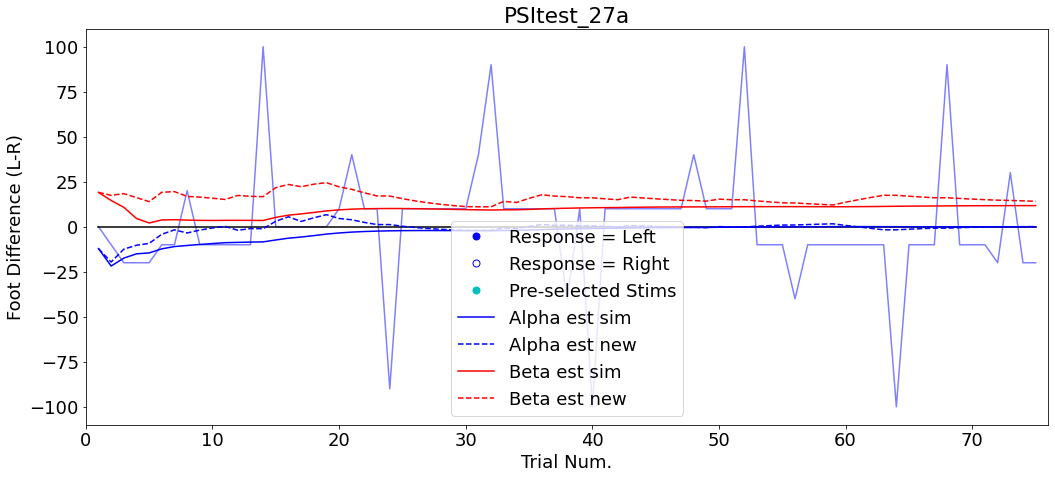

('PSItest_27', 'b')


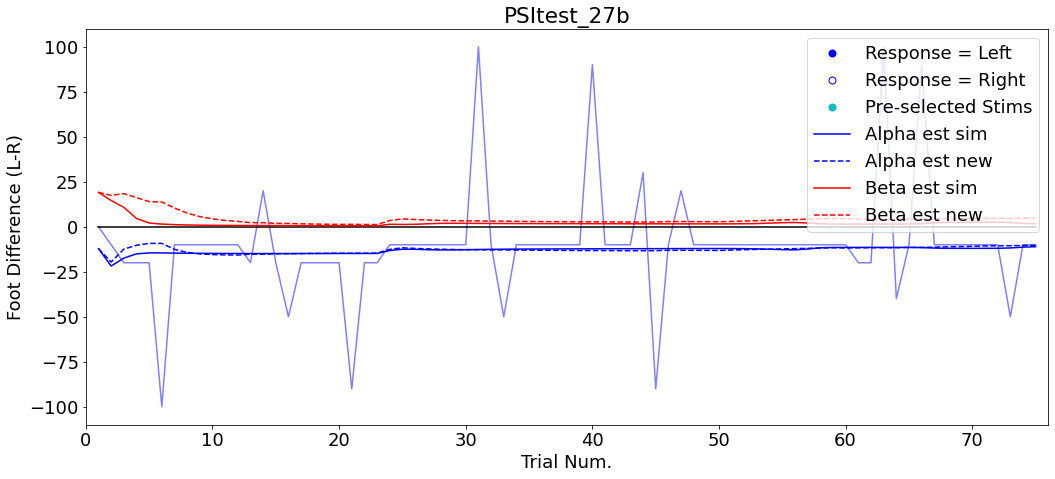

('PSItest_28', 'a')


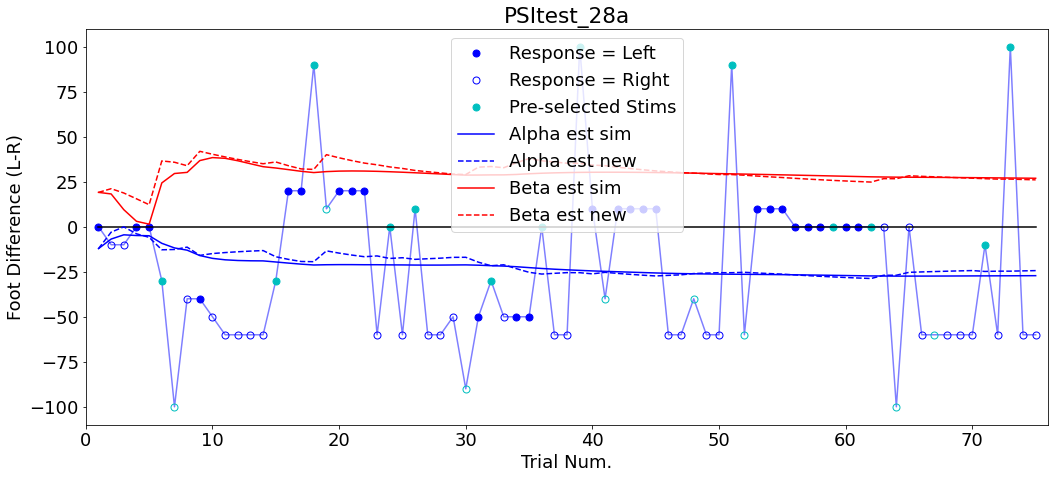

('PSItest_28', 'b')


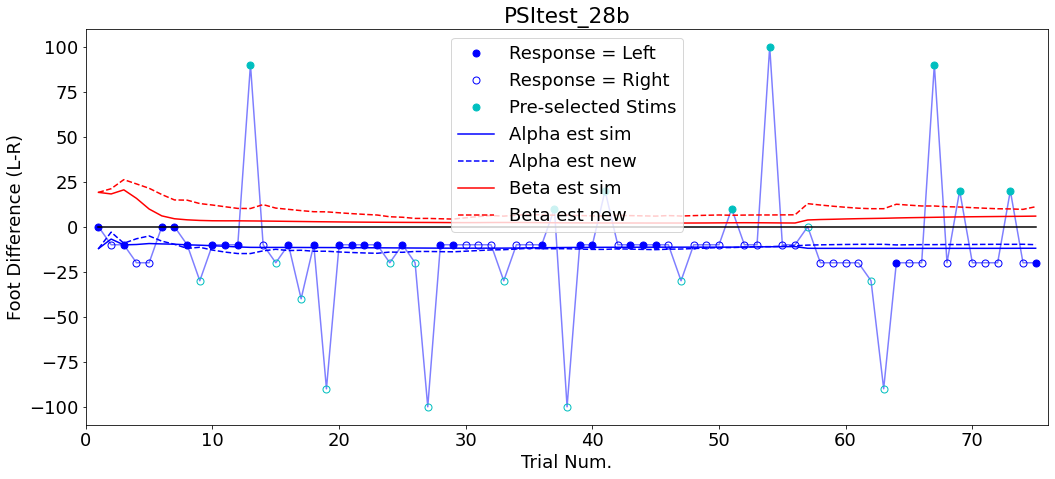

('PSItest_29', 'a')


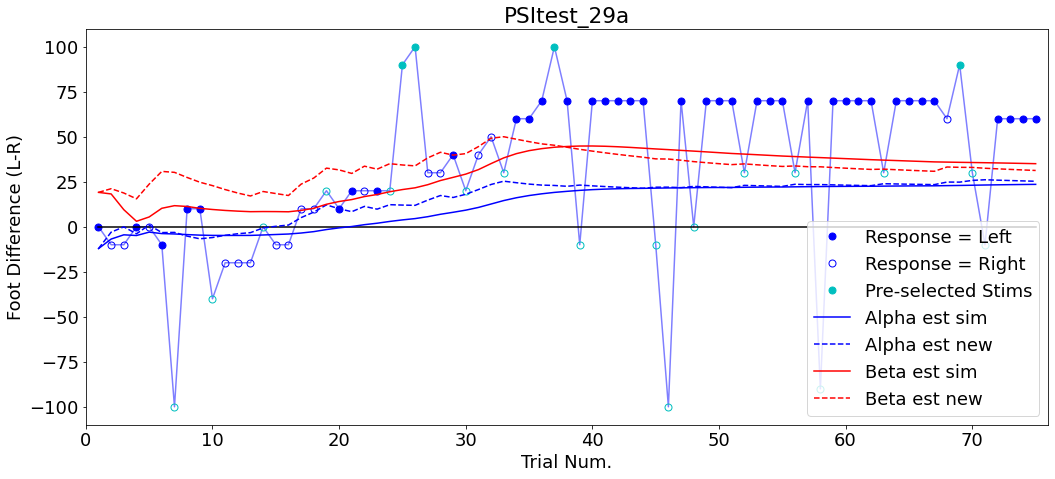

('PSItest_29', 'b')


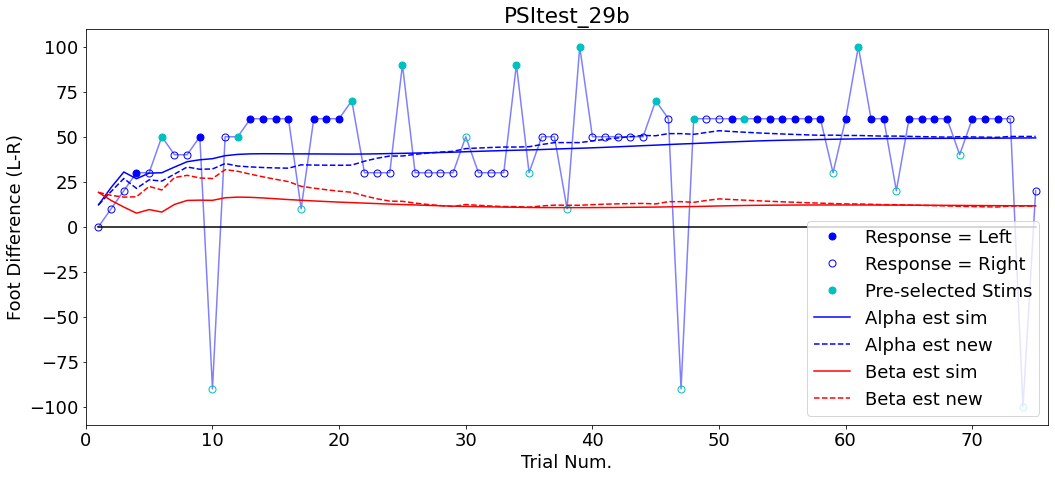

('PSItest_30', 'a')


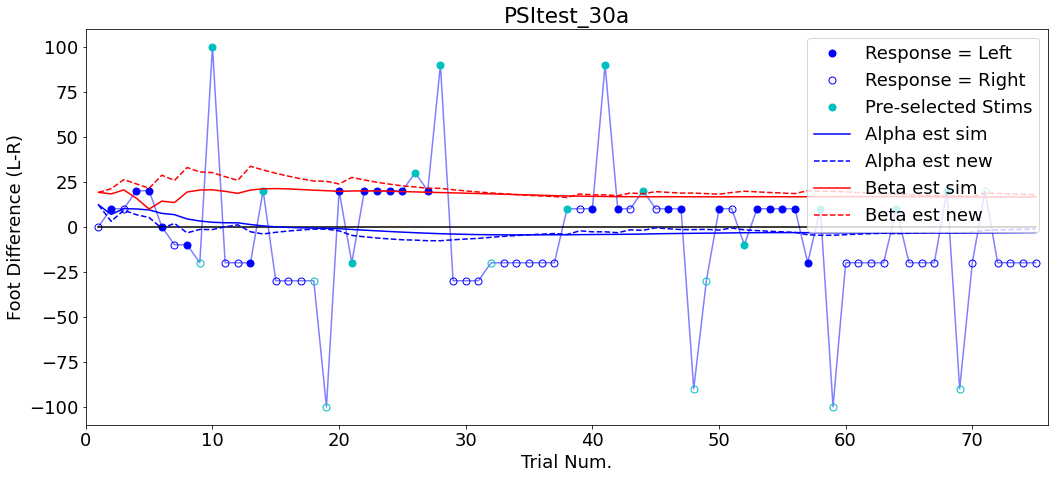

('PSItest_30', 'b')


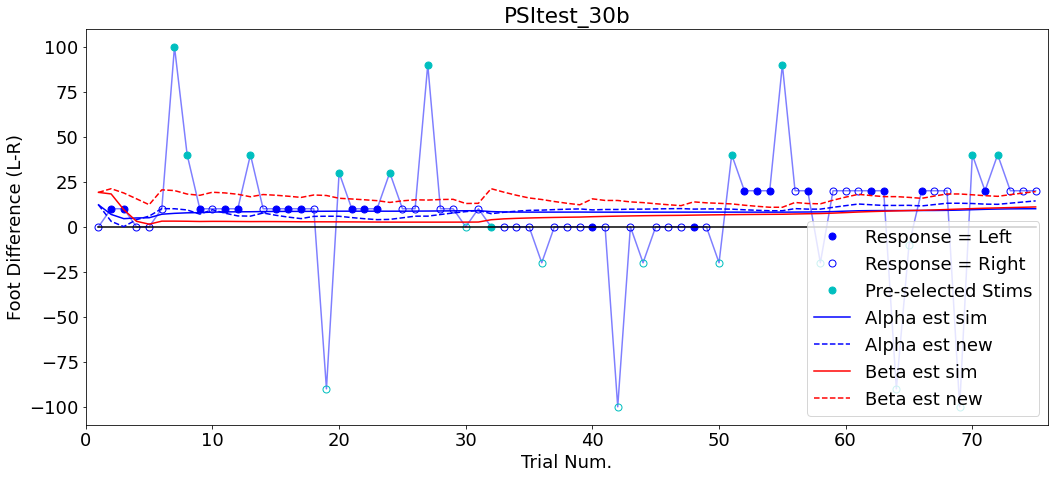

('PSItest_31', 'a')


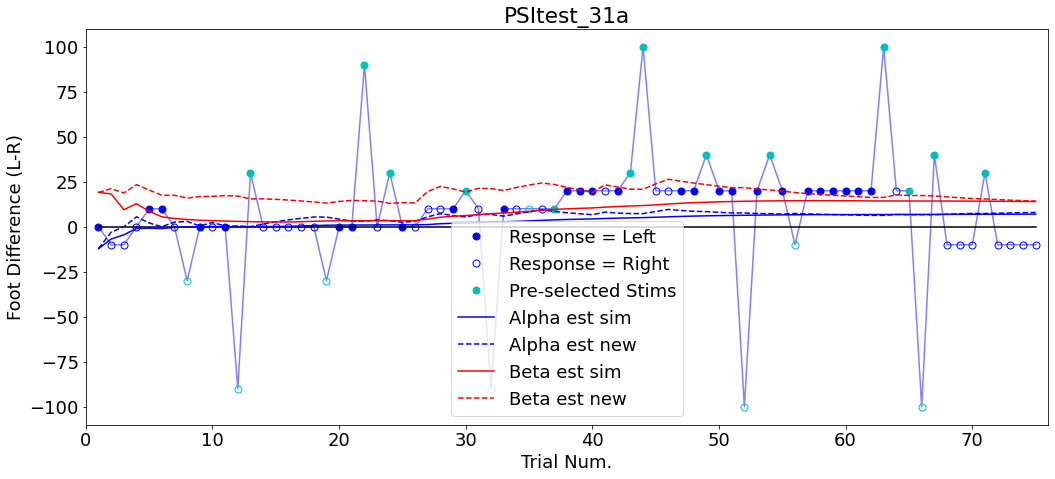

('PSItest_31', 'b')


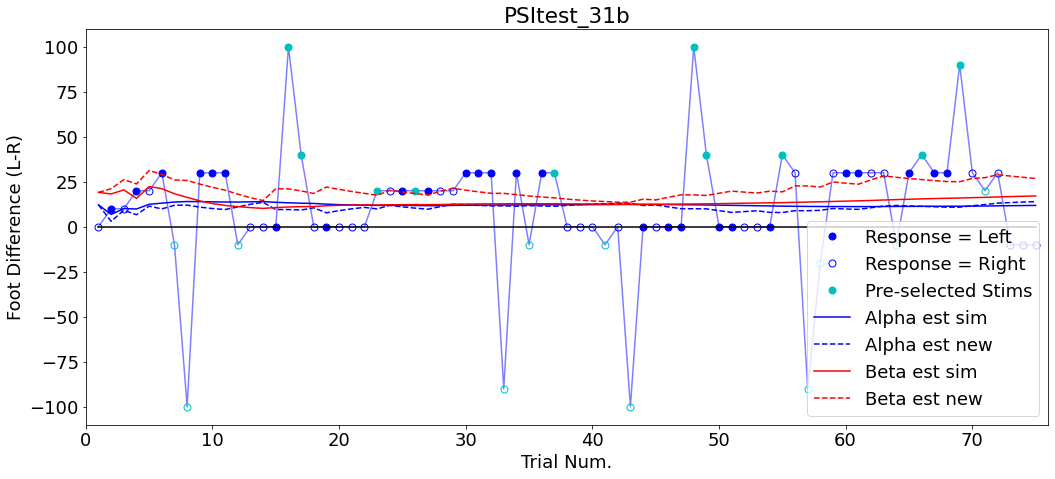

In [25]:
Aest1, Aest2, Best1, Best2 = [],[],[],[]
for name, test in grp_tests:
    alpha_EV_1, alpha_EV_2, beta_EV_1, beta_EV_2 = compare_post_calcs(test)
    Aest1 = np.append(Aest1, alpha_EV_1[-1])
    Aest2 = np.append(Aest2, alpha_EV_2[-1])
    Best1 = np.append(Best1, beta_EV_1[-1])    
    Best2 = np.append(Best2, beta_EV_2[-1]) 